# Homework 10: ResNet

In this homework you will be building a simplified ResNet model to classify images from the Cifar-10 dataset. You will need to change the runtime type to GPU to train in a reasonable amount of time on this homework.

Note that google limits your GPU usage somewhat, so be efficient with your use! The final training run will take around half an hour. We recommend "babysitting" it: if it looks like its producing different results than our output that we provide to you, stop it and go try to debug.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
from torchvision import transforms, datasets
# Make sure to change your runtime type to GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

####Download and prepare the data

In [2]:
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

# DO NOT CHANGE
print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

==> Preparing data..


100%|██████████| 170498071/170498071 [00:01<00:00, 106874412.56it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


####1.a Define a convolutional block and simplified ResNet model (80 pts)

Fill in the forward passes for the basic block and resnet modules below. The module should have two different behaviors depending on whether `in_channels == out_channels`. If `in_channels==out_channels`, then the module should wrap two conv layers in a residual connection as shown on the left below. Otherwise, the module should only wrap the second conv layer in a residual connection as shown on the right below.


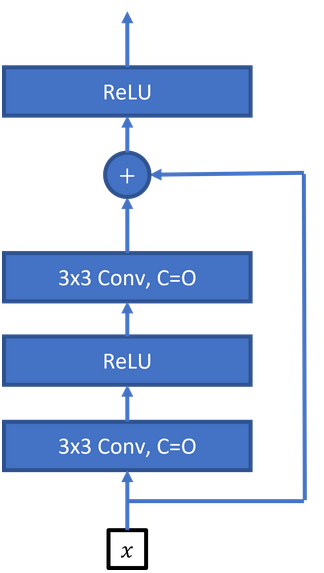 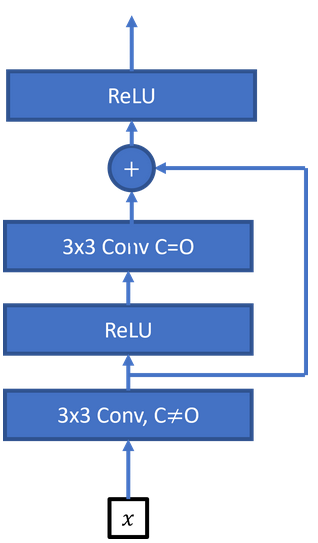

In [3]:
class BasicBlock(nn.Module):

    def __init__(self, in_channels, out_channels):
        super(BasicBlock, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.conv1 = nn.Conv2d(
            in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)

    def forward(self, x):
        '''
        Pass the input through the layers as depicted in the diagram above
        If the input channels are the same as the output channels, add a residual connection before the final ReLU.
        Note that you will need to change the the location of the residual connection depending on the input and output channels.
        '''
        #ADD CODE HERE
        if next(self.conv1.parameters()).device != x.device:
            self.conv1.to(x.device)
            self.conv2.to(x.device)
        if self.in_channels == self.out_channels:
          con1 = self.conv1(x)
          relu1 = nn.functional.relu(con1)
          con2 = self.conv2(relu1)
          res1 = con2 + x
          out = nn.functional.relu(res1)
          return out
        else:
          con1 = self.conv1(x)
          relu1 = nn.functional.relu(con1)
          con2 = self.conv2(relu1)
          res1 = con2 + con1
          out = nn.functional.relu(res1)
          return out

          #think this works??






The Resnet18 model will be connected as shown in the following diagrams. The first diagram below shows the connections in terms of the "BasicBlock" module you implemented above. The second diagram shows the connections with all the conv layers included, but omits ReLUs to simplify the diagram a bit.

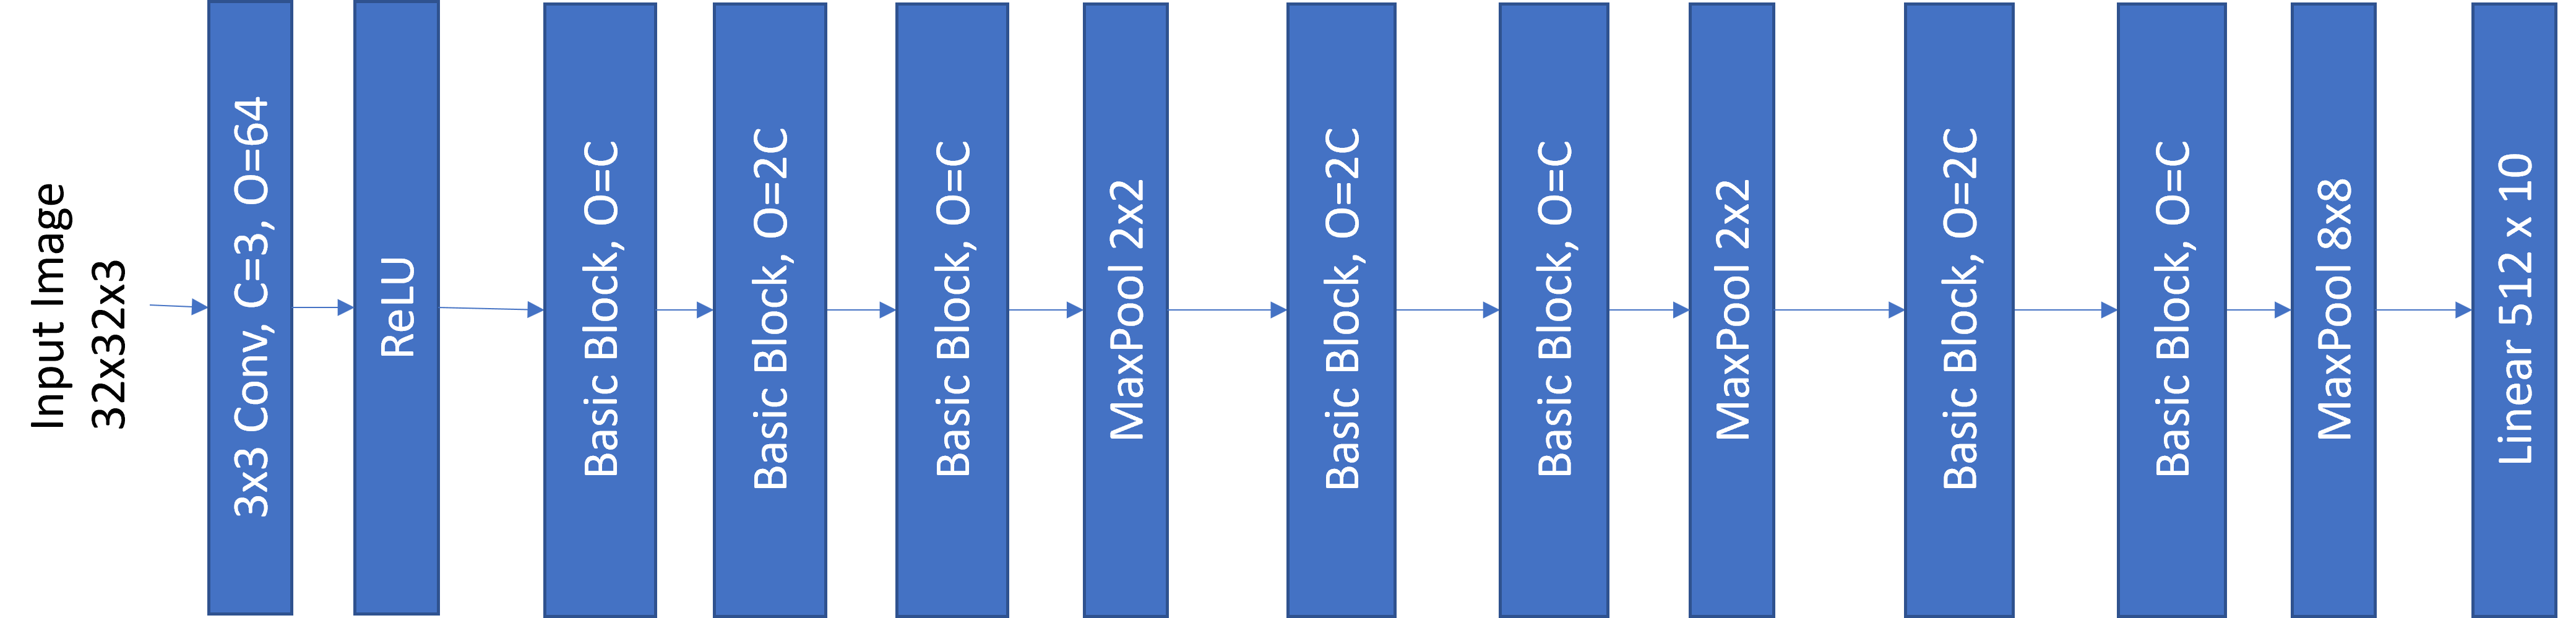

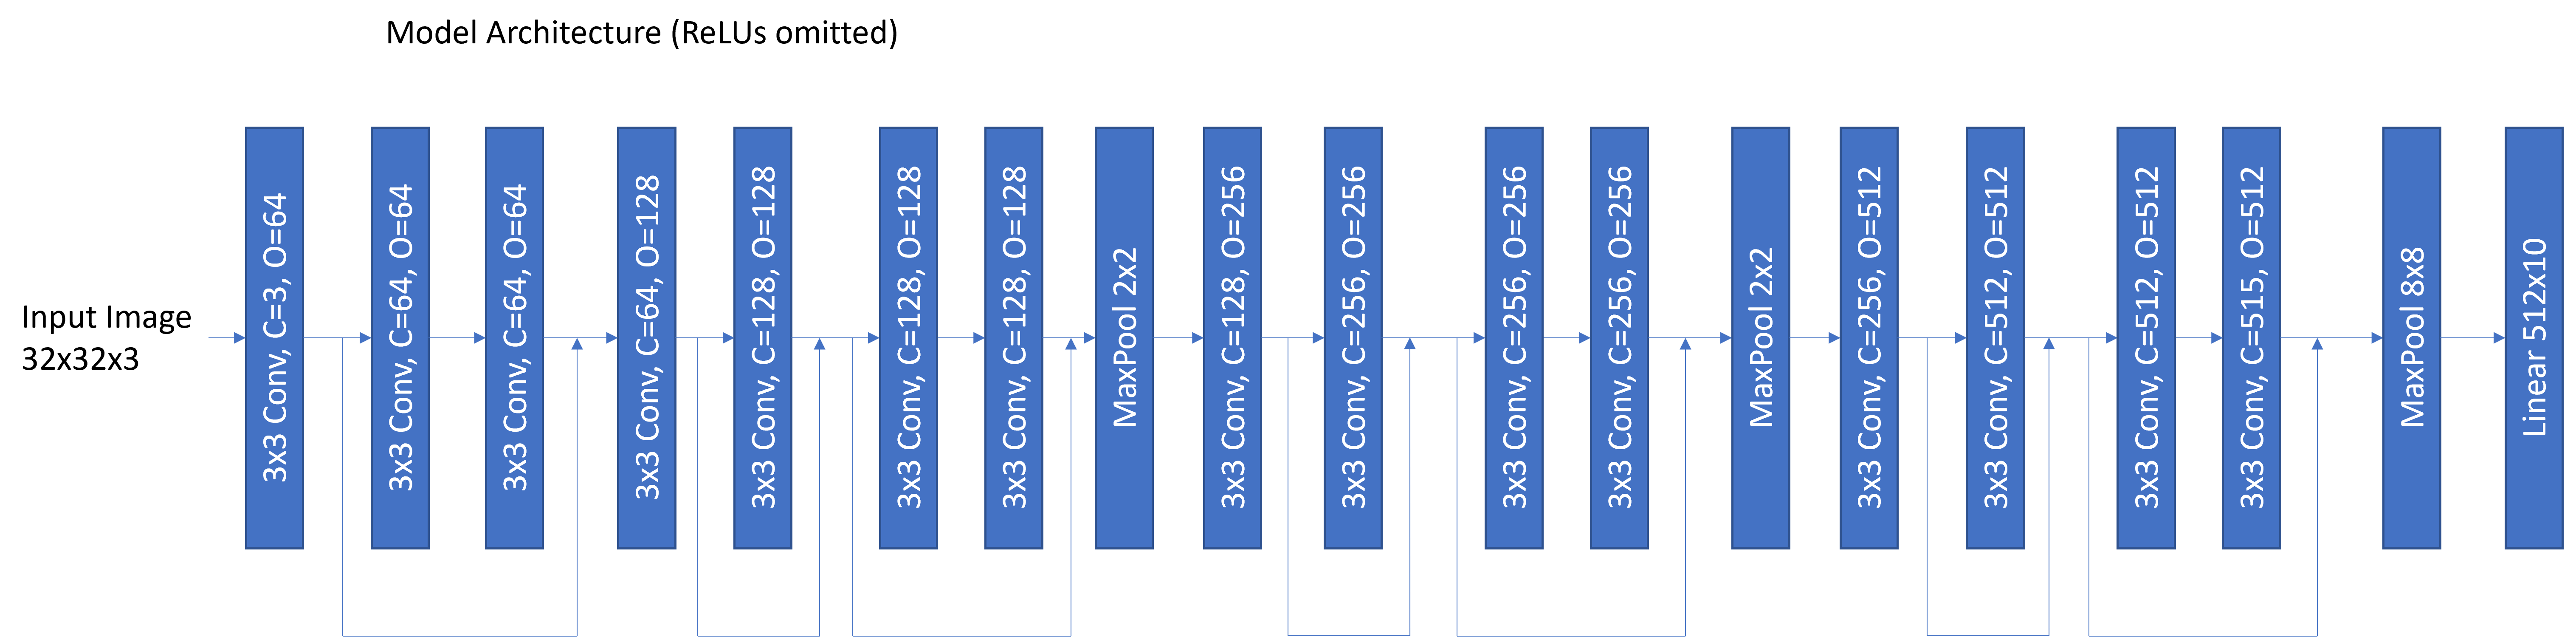

In [4]:
class SimplifiedResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(SimplifiedResNet, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.layer1 = self._make_layer(block, 64, 64)
        self.layer2 = self._make_layer(block, 64, 128)
        self.layer3 = self._make_layer(block, 128, 256)
        self.layer4 = self._make_layer(block, 256, 512)
        self.linear = nn.Linear(512, num_classes)

    def _make_layer(self, block, in_planes, out_planes):
        layers = [
            block(in_planes, out_planes),
            block(out_planes, out_planes)
        ]
        return nn.Sequential(*layers)

    def forward(self, x):
        '''
        Pass the input through each of the layers above as shown in the diagram.
        The make layer function already defines how many blocks of each kind so you only need to call each function once.
        You will also need to call F.relu and F.max_pool2d for the layers not defined above.
        '''
        # ADD CODE HERE
        #first conv
        # Pass through convolutional layers and max pooling
        x = self.conv1(x)
        x = F.relu(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = F.max_pool2d(x, 2,2)  # Assuming kernel_size=2 and stride=2
        x = self.layer3(x)
        x = F.max_pool2d(x, 2,2)  # Assuming kernel_size=2 and stride=2
        x = self.layer4(x)
        x = F.max_pool2d(x, 8,8)  # Assuming kernel_size=8 and stride=8
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        return x








<!-- **bold text**####1.b  -->
Now, we initialize your model, and define the optimizer. We will use SGD with momentum. The `weight_decay` option also adds a small amount of L2 regularization.

In [5]:
print('==> Building model..')
net = SimplifiedResNet(BasicBlock, [2, 2, 2, 2])
net = net.to(device)
# net.cuda()
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

==> Building model..


####1.b Finish train and test functions in `train_epoch` and `test` (20 pts)



In [6]:
def train_epoch(epoch, net, optimizer, trainloader):
    '''
    Function should iterate through the trainloader, pass the inputs through the network, compute the loss given the outputs,
    call backward() on the loss, and step the optimizer.

    arguments:
      epoch: current epoch, integer.
      net: torch.nn.Module object for convnet to train.
      optimizer: optimizer class for training.
      trainloader: pytorch DataLoader for the training set

    no return value
    '''
    print('\nEpoch: %d' % epoch)
    # net.train() below is good practice when performing testing or evaluation.
    # In this case, it has no effect, but there are more complicated networks
    # for which the architecture is deliberately different during training vs evaluation.
    net.train()
    # use the crossentropyloss as your loss function.
    criterion = nn.CrossEntropyLoss()
    # ADD CODE HERE
    for i, data in enumerate(trainloader, 0):
      # data = data.to(device)
      inputs, labels = data

      optimizer.zero_grad()

      outputs = net(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
    print("\n epoch finished")








Your test function should loop through the test data and return the % accuracy of the model.

In [7]:
def test(net, testloader):
    '''
    Function should iterate through testloader and return a variable acc that is the total test accuracy score for the current model
    arguments:
      net: torch.nn.Module object for convnet to evaluate.
      testloader: pytorch DataLoader for the testing set.

    returns:
      float value from 0 to 100 holding the accuracy on the test set for this model.
    '''
    # net.eval() below is good practice when performing testing or evaluation.
    # In this case, it has no effect, but there are more complicated networks
    # for which the architecture is deliberately different during training vs evaluation.
    net.eval()
    total = 0.0
    correct = 0
    # ADD CODE HERE
    with torch.no_grad():
      for data in testloader:
          images, labels = data
          # calculate outputs by running images through the network
          outputs = net(images)
          # the class with the highest energy is what we choose as prediction
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

      print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

    return 100 * correct // total

####1.c Train the model (10 pts)
For each epoch, train the model, call the test function to get the accuracy score for the epoch, append that accuracy to the list `accs`, and step the scheduler to update the learning rate. Running through 30 epochs should take ~30 minutes and your final accuracy should be ~89%.

We have left the output of our implementation in the cell below **DO NOT WAIT 30 minutes to find out you did not obtain high accuracy: if your output looks very different from ours in the early epochs, stop your training run early and go debug!**

Note that more advanced optimization schemes (or even just running longer with a simple scheme like this one) can improve this accuracy.

In [9]:
accs = []
# net = SimplifiedResNet(BasicBlock, )
for epoch in range(30):
    # ADD CODE HERE
    # it is recommended to print out the Test accuracy after each epoch so that you can compare your progress
    # to the reference output.
    train_epoch(epoch, net, optimizer, trainloader)
    # print("\n accuracy: " + str(test(net, testloader)))
    accs.append(test(net, testloader))






Epoch: 0

 epoch finished
Accuracy of the network on the 10000 test images: 52.0 %

Epoch: 1

 epoch finished
Accuracy of the network on the 10000 test images: 63.0 %

Epoch: 2

 epoch finished
Accuracy of the network on the 10000 test images: 74.0 %

Epoch: 3

 epoch finished
Accuracy of the network on the 10000 test images: 79.0 %

Epoch: 4

 epoch finished
Accuracy of the network on the 10000 test images: 80.0 %

Epoch: 5

 epoch finished
Accuracy of the network on the 10000 test images: 82.0 %

Epoch: 6

 epoch finished
Accuracy of the network on the 10000 test images: 82.0 %

Epoch: 7

 epoch finished
Accuracy of the network on the 10000 test images: 84.0 %

Epoch: 8

 epoch finished
Accuracy of the network on the 10000 test images: 84.0 %

Epoch: 9

 epoch finished
Accuracy of the network on the 10000 test images: 85.0 %

Epoch: 10

 epoch finished
Accuracy of the network on the 10000 test images: 84.0 %

Epoch: 11

 epoch finished
Accuracy of the network on the 10000 test image

###1.d: Plot the accuracy over time (10 pts)

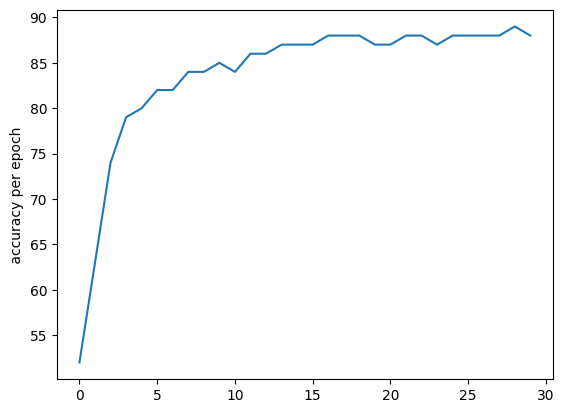

In [10]:
import matplotlib.pyplot as plt
import numpy as np
# Produce a plot of the test accuracy on the y-axis and epoch count on the x-axis.
# ADD CODE HERE
# accs = [1,2,3]
plt.plot(accs)
plt.ylabel(" accuracy per epoch ")
plt.show()




Now, we get the predicted labels for a batch of the testing data and plot 9 of the images with their labels. From looking at the pictures you can get an idea of the difficulty of this task. One anecdotal human-level classification accuracy is only 94% (http://karpathy.github.io/2011/04/27/manually-classifying-cifar10/), which is about the same (actually slightly worse) than what a real non-simplified ResNet model would achieve.

In [11]:
iterator = iter(testloader)
x_batch, y_batch = next(iterator)

with torch.no_grad():
    inputs, targets = x_batch.to(device),y_batch.to(device)
    outputs = net(inputs)
    _,predicted = outputs.max(1)

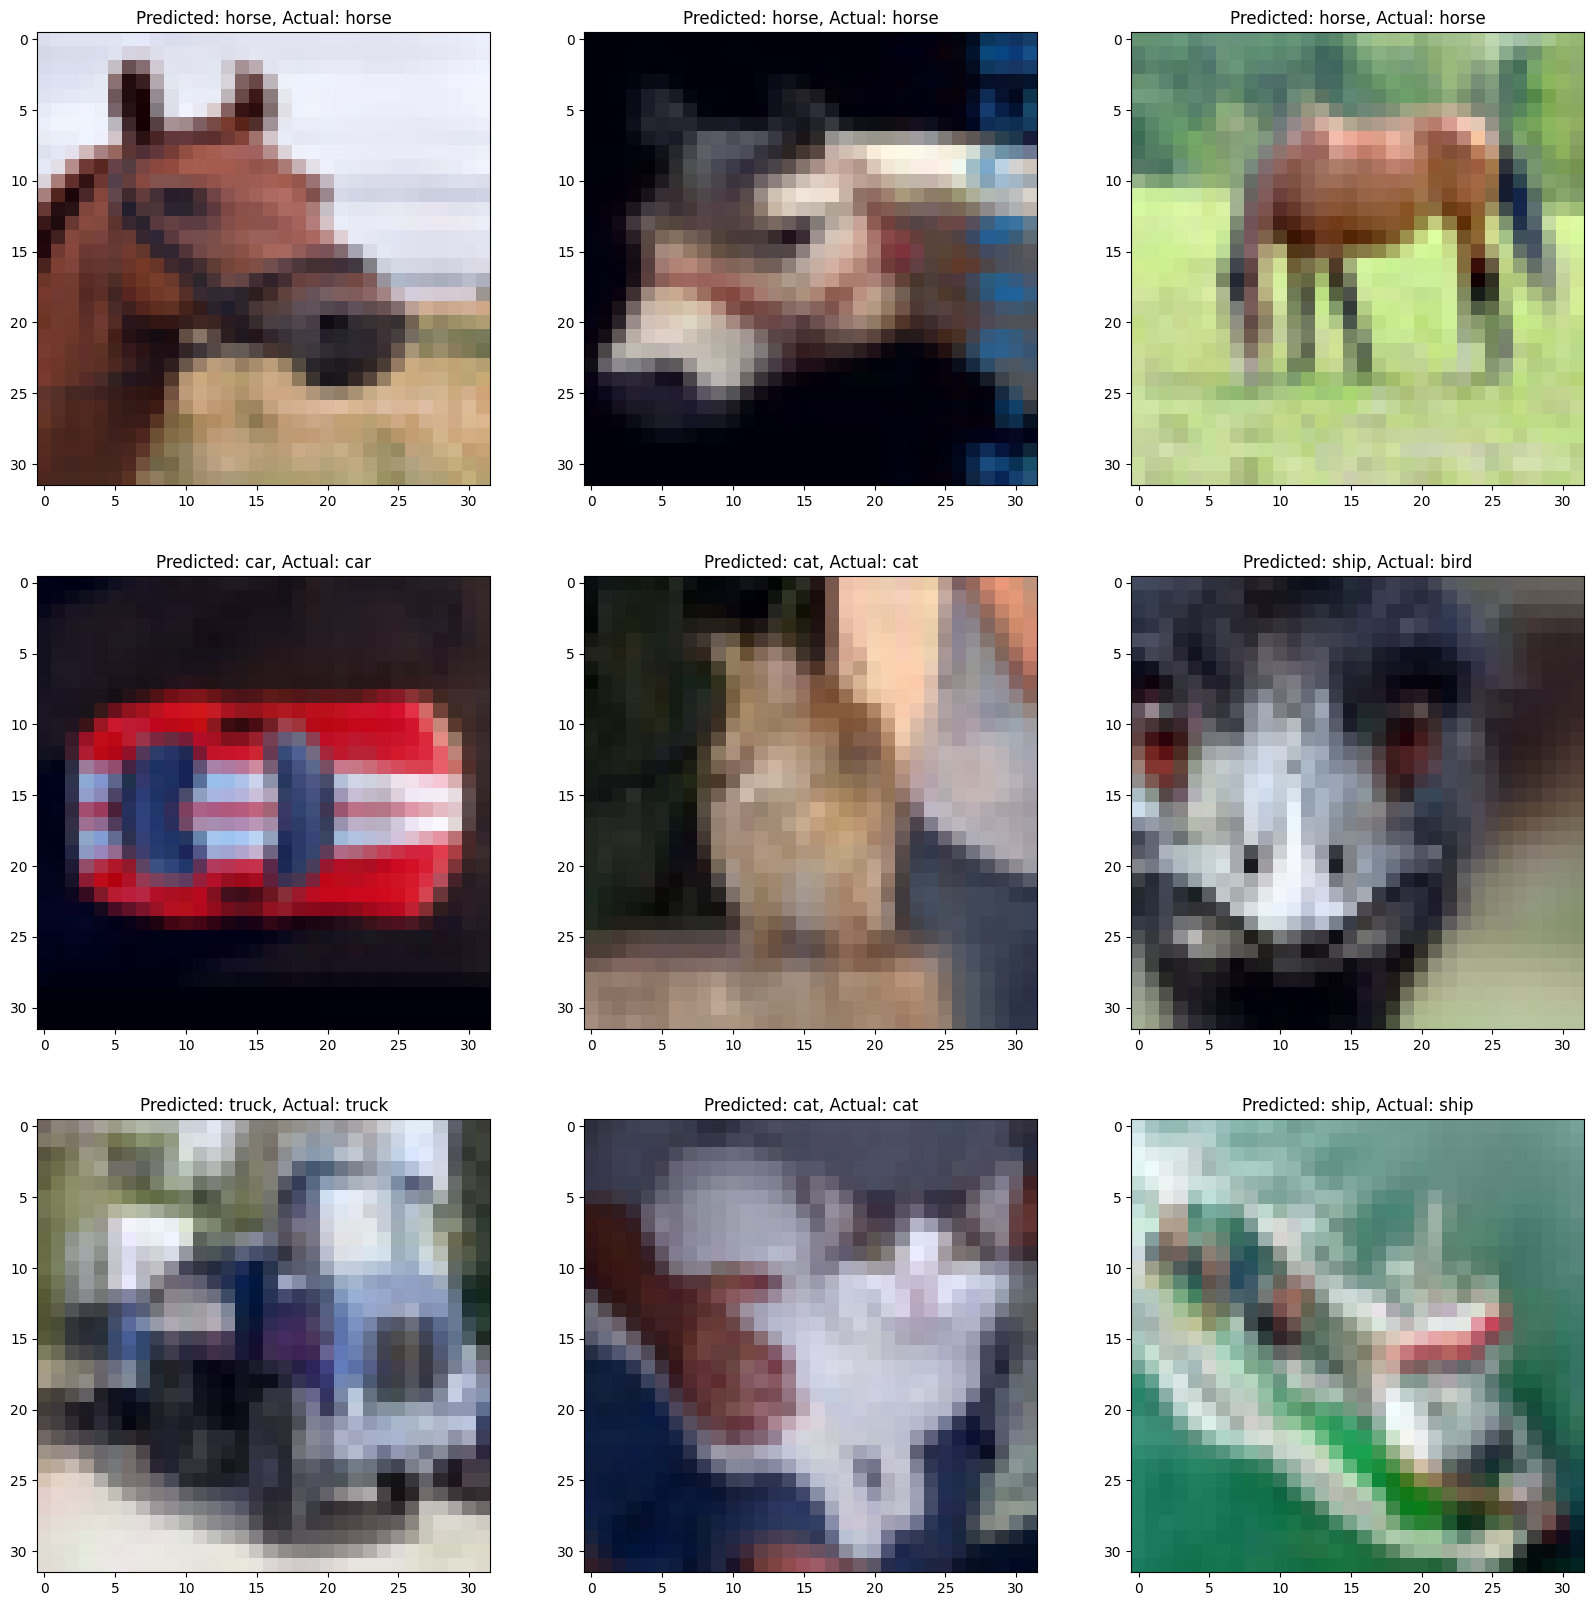

In [12]:
fig, axs = plt.subplots(3,3,figsize = (20,20))

inds = np.random.randint(1,inputs.shape[0],size = 9)
count = 0

for i in np.arange(3):
  for j in np.arange(3):
    image = x_batch[inds[count]].reshape(3,32,32).numpy()
    image = image.transpose(1,2,0)
    image -= image.min()
    image /= image.max()
    axs[i,j].imshow(image)
    title = "Predicted: " + classes[predicted[inds[count]]] + ", Actual: " + classes[y_batch[inds[count]]]
    axs[i,j].title.set_text(title)
    count += 1